# CSE527 Homework 3
**Due date: 23:59 on 11/06, 2018 (Tuesday)**

## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 15 categories by training and testing on the 15
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---
The starter code trains and tests on 100 images from each category (i.e. 1500
training examples total and 1500 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.
Download the dataset
[here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing). <br>

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder,
there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Delete** the data subfolder before submission or the blackboard won't let you do so because
of the size. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.6% accuracy
(1 out of 15 guesses is correct).

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
from sklearn.cluster import MiniBatchKMeans
import random
import time
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

In [2]:
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('data/train/')
train_num = len(train_label)

# load testing dataset
test_data, test_label = load_dataset('data/test/', 100)
test_num = len(test_label)

# feature extraction
def extract_feat(raw_data):
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in xrange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
        
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(15) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in xrange(test_num):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(test_num)

print "The accuracy of my dummy model is {:.2f}%".format(accuracy*100)

The accuracy of my dummy model is 6.00%


### Helper Methods

In [3]:
class NearestNeighbour:
    def __init__(self):
        print("Nearest Neighbour Classifier initialized")
        self._data = None
        self._label = None
        
    def fit(self, train_data, train_label):
        self._data = train_data
        self._label = train_label
        
    # compute L2 distance
    def compute_L2(self, img1, img2):
        return np.sum(np.square(img1) + np.square(img2) - 2 * np.multiply(img1, img2))

    def predict(self, test):
        pred_labels = []
        for img1 in test:
            label_idx = np.argmin([self.compute_L2(img1, img2) for img2 in self._data])
            pred_labels.append(self._label[label_idx])
        return pred_labels

class Timer:
    def __init__(self):
        self._total = 0.0
        self._events = []
    
    @property
    def total(self):
        '''Returns total time'''
        return self._total

    def add(self, event, x):
        '''Adds an event with time taken by the event'''
        self.total += x
        self._events.append((event,x))
        print("%s took %f s" % (event, x))
    
    @property
    def event(self):
        '''Returns events recorded'''
        return self._events

class DenseSIFT:
    def __init__(self, step_size, scale_size):
        self._step = step_size
        self._scale = scale_size
        self._sift = cv2.xfeatures2d.SIFT_create()

    def compute_features(self, img):
        '''Computes the dense descriptors for input image'''
        kp = [cv2.KeyPoint(x, y, self._scale) for y in range(0, img.shape[0], self._step) 
                                    for x in range(0, img.shape[1], self._step)]
        kp, des = self._sift.compute(img, kp)
        return des

def sample_images(images, labels, sample_size = -1):
    '''Returns a subset of size sample_size from each class of images'''
    if sample_size < 0:
        return images, labels
    label_counts = Counter(labels)
    sample_images = []
    sample_labels = []
    idx = 0
    for label in label_counts:
        sample_images += random.sample(images[idx: label_counts[label] + idx], sample_size)
        sample_labels += [label] * sample_size
        idx += label_counts[label]
    return sample_images, sample_labels
    
def convert_to_tiny(img, size = (16,16)):
    '''Converts given image to tiny image with a size parameter'''
    normalized = zero_mean_unit_length(img)
    resized = cv2.resize(normalized, size)
    return resized

def zero_mean_unit_length(img):
    '''Converts image to have zero mean and unit length'''
    zero_mean = img - np.mean(img)
    unit_length = zero_mean / np.linalg.norm(zero_mean)
    return unit_length

def compute_histogram(img, sift, kmeans, n_bins):
    '''Computes histogram of SIFT features based on pre-computed clusters (kmeans)'''
    descriptors = sift.compute_features(img)
    histogram = np.zeros(n_bins)
    preds = kmeans.predict(descriptors)
    for pred in preds:
        histogram[pred] += 1
    return histogram

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

c_names = [name[11:] for name in glob.glob('data/train/*')]

## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;

- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [4]:
# Write your codes here
tiny_train_data = []
tiny_test_data = []

# create a timer
timer = Timer()

a = time.time()
# convert each image in train to tiny image
for img in train_data:
    tiny_train_data.append(np.reshape(convert_to_tiny(img), (1,-1))[0])

# convert each image in test to tiny image
for img in test_data:
    tiny_test_data.append(np.reshape(convert_to_tiny(img), (1,-1))[0])
timer.add('Data Pre-processing', time.time() - a)

a = time.time()
# Create Nearest Neighbours model
nn = NearestNeighbour()
nn.fit(tiny_train_data, train_label)
pred1 = nn.predict(tiny_test_data)

# Find accuracy of model
accuracy = sum(np.array(pred1) == test_label) / float(len(test_label))
print "The accuracy of first model is {:.2f}%".format(accuracy*100)
timer.add("Nearest Neighbour Classifier", time.time() - a)

print("Total time taken = %f s" % timer.total)

Data Pre-processing took 0.750385 s
Nearest Neighbour Classifier initialized
The accuracy of first model is 21.47%
Nearest Neighbour Classifier took 23.141938 s
Total time taken = 23.892323 s


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [5]:
#-----------------------------------------------------------------------------------------
# SIFT Parameters
SCALE = 16
STEP_SIZE = 8
IMAGE_SAMPLE_SIZE = -1

# K-Means prameters
N_CLUSTERS = 200
BATCH_SIZE = 400
MAX_ITER = 10

# Histogram Parameters
N_BINS = N_CLUSTERS

#------------------------------------------------------------------------------------------

# Obtain training data
train_sub_data, train_sub_label = sample_images(train_data, train_label, IMAGE_SAMPLE_SIZE)    
    
# Create a SIFT object
sift = DenseSIFT(STEP_SIZE, SCALE)
print('DenseSIFT initialized')

# Create a timer object
timer = Timer()

# Compute Features for train data
a = time.time()
feat = np.vstack([sift.compute_features(img) for img in train_sub_data])
timer.add('Features computation for training subset', time.time() - a)

# Compute clusters using KMeans
a = time.time()
model = MiniBatchKMeans(n_clusters = N_CLUSTERS, 
                        random_state = 0, 
                        batch_size=BATCH_SIZE, 
                        max_iter=MAX_ITER)
kmeans = model.fit(feat)
timer.add('K-Means clustering', time.time() - a)

# Initialize histogram
train_histogram = np.zeros((len(train_data), N_BINS))
test_histogram = np.zeros((len(test_data), N_BINS))

a = time.time()
# compute train histogram
for idx, img in enumerate(train_data):
    train_histogram[idx] = compute_histogram(img, sift, kmeans, N_BINS)

# compute test histogram
for idx, img in enumerate(test_data):
    test_histogram[idx] = compute_histogram(img, sift, kmeans, N_BINS)

timer.add('Histogram Computation', (time.time() - a))  

# Create Nearest Neighbours model
a = time.time()
nn = NearestNeighbour()
nn.fit(train_histogram, train_label)
pred2 = nn.predict(test_histogram)
    
# Find accuracy of model
accuracy = sum(np.array(pred2) == test_label) / float(len(test_label))
print "The accuracy of second model with NN is {:.2f}%".format(accuracy*100)
timer.add('Nearest Neighbours Model', time.time() - a)

print("Total time taken = %f s" % timer.total)

DenseSIFT initialized
Features computation for training subset took 226.194998 s
K-Means clustering took 39.900770 s
Histogram Computation took 458.842879 s
Nearest Neighbour Classifier initialized
The accuracy of second model with NN is 48.33%
Nearest Neighbours Model took 24.675712 s
Total time taken = 749.614359 s


## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{20 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 15-way classification problem
(the library has handled it for you). To decide which of 15 categories a test
case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: 10 points will be given to students whose accuracy
  ranks top 3 in this homework. Don't cheat and don't train your model on
  testing data, a separate testing dataset will be used to evaluate your model.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [7]:
# ------------------------------------------------------------------------------------------
# SIFT Parameters
SCALE = 8
STEP_SIZE = 8
IMAGE_SAMPLE_SIZE = -1

# K-Means prameters
N_CLUSTERS = 400
BATCH_SIZE = 400
MAX_ITER = 10

# Histogram Parameters
N_BINS = N_CLUSTERS

# SVM Parameters
C_PENALTY = 1.0
TOLERANCE = 1e-5
# ------------------------------------------------------------------------------------------

train_sub_data, train_sub_label = sample_images(train_data, train_label, IMAGE_SAMPLE_SIZE)    
    
# Create a SIFT object
sift = DenseSIFT(STEP_SIZE, SCALE)
print('DenseSIFT initialized')

# Create a timer object
timer = Timer()

# Compute Features for train data
a = time.time()
feat = np.vstack([sift.compute_features(img) for img in train_sub_data])
timer.add('Features computation for training subset', time.time() - a)

# Compute clusters using KMeans
a = time.time()
model = MiniBatchKMeans(n_clusters = N_CLUSTERS, 
                        random_state = 0, 
                        batch_size=BATCH_SIZE, 
                        max_iter=MAX_ITER)
kmeans = model.fit(feat)
timer.add('K-Means clustering', time.time() - a)

# Initialize histogram
train_histogram = np.zeros((len(train_data), N_BINS))
test_histogram = np.zeros((len(test_data), N_BINS))

a = time.time()
# compute train histogram
for idx, img in enumerate(train_data):
    train_histogram[idx] = compute_histogram(img, sift, kmeans, N_BINS)

# compute test histogram
for idx, img in enumerate(test_data):
    test_histogram[idx] = compute_histogram(img, sift, kmeans, N_BINS)

timer.add('Histogram Computation', (time.time() - a))  

a = time.time()
clf = LinearSVC(random_state=0, tol= TOLERANCE, dual = False, C = C_PENALTY)
clf.fit(train_histogram, train_label)

pred3 = clf.predict(test_histogram)
# Find accuracy of model
accuracy = sum(np.array(pred3) == test_label) / float(len(test_label))
print "The accuracy of third model with Multi-Class SVM is {:.2f}%".format(accuracy*100)
timer.add('Multi-Class SVM', time.time() - a)

print("Total time taken = %f s" % timer.total)

DenseSIFT initialized
Features computation for training subset took 61.973322 s
K-Means clustering took 74.430331 s
Histogram Computation took 150.991254 s
The accuracy of third model with Multi-Class SVM is 62.07%
Multi-Class SVM took 10.560399 s
Total time taken = 297.955306 s


## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 50-60%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 60-70%). <br>

**1. Tiny Images and Nearest Neighbour:** <br>

-- Time consumed and prediction accuracy
   1. Total time taken = 23.89 s
   2. Prediction Accuracy = 21.47%

-- Algorithm descriptions and discussions <br>
   1. First, the train and test images are converted to tiny images of size (16,16).
   2. Second, the nearest neighbours classifier was implemented. It works by comparing each test image with every train image using the L2 distance metric (Euclidean distance) and then assigning the class of the train image that was closest to the given test image.
   
   The algorithm becomes expensive when the number of train and test images becomes large. O(n_train * n_test) <br>

-- Confusion matrix observations

   The confusion matrix shows that most categories were incorectly predicted as Coast, Highway or OpenCountry.

Normalized confusion matrix


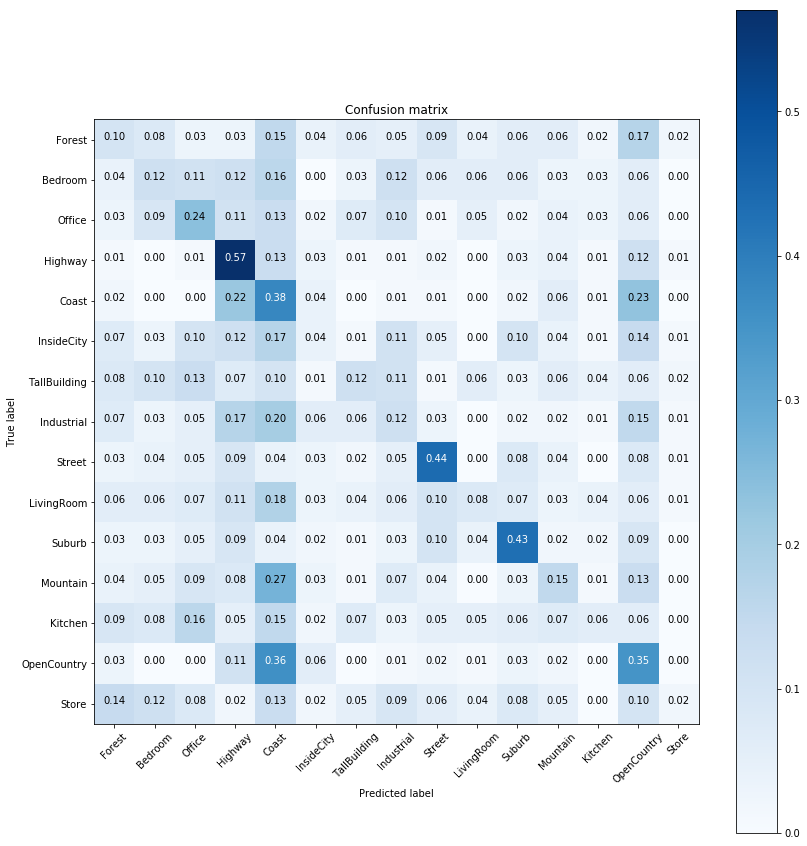

In [11]:
#First combination:
# Confusion matrix
cm1 = confusion_matrix(test_label, pred1)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True)
plt.show()

**2. Bag of SIFT Representation and Nearest Neighbour:** <br>

-- Time consumed and prediction accuracy
   1. Total time taken = 749 s
   2. Prediction Accuracy = 48.33%

-- Algorithm descriptions and discussions
   
   1. First, the dense SIFT features are calculated for each image in the training set.
   2. Second, these features are a 128 dimensional matrix and they are passed into the Mini-batch Kmeans clustering algorithm (with a pre-defined number of clusters, which become the number of visual words). This gives us the cluster centroids.
   3. Then the clusters are used to compute the histograms (n_bins = n_clusters) for each image in train and test. The histogram represents the visual word count for each image.
   4. Finally, the test histograms are passed into the Nearest neighbours classifier to compare against the train histograms and the label of the nearest neighbour is assigned to each test case.


| Scale | Step |    Clusters     | Batch Size | Q2-Total Time (s) | Q2-Accuracy |
|-------|------|-----------------|------------|-------------------|-------------|
| 20    | 10   | 50              | 20         | 710               | 45.07%      |
| 16    | 8    | 100             | 300        | 895               | 47.40%      |
| 12    | 6    | 150             | 500        | 753               | 45.40%      |
| 16    | 8    | 200             | 400        | 683               | 48.33%      |
| 16    | 8    | 400             | 800        | 704               | 47.53%      |
| 8     | 8    | 300             | 400        | 300               | 45.07%      |
| 8     | 8    | 350             | 400        | 298               | 43.40%      |
| 8     | 8    | 400             | 400        | 317               | 44.40%      |
| 8     | 8    | 450             | 1000       | 318               | 44.40%      |
| 4     | 4    | 400             | 400        | 565               | 46.67%      |
    
  Several parameters were tried and are tabulated above. With 200 clusters and step-size of 8 and scale of 16, the best model was obtained.

-- Confusion matrix observations

   1. Living Room, Office and Kitchen were incorrectly classified as Bedroom almost 30% of the time.
   2. Highway, Forest, Street and Suburb were the best performing classes.
   3. Industrial is misclassified as other class most of the time.


Normalized confusion matrix


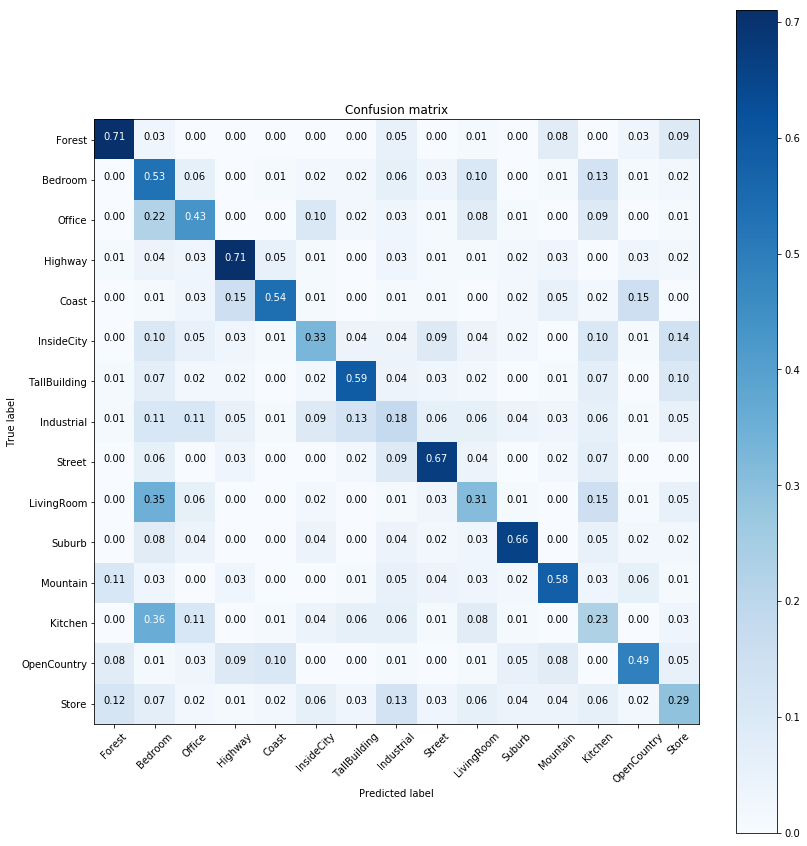

In [12]:
#Second combination:
# Confusion matrix
cm2 = confusion_matrix(test_label, pred2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()

**Bag of SIFT Representation and Multi-Class SVM:** <br>

-- Time consumed and prediction accuracy
   1. Total time taken = 298 s
   2. Prediction Accuracy = 62.07%

-- Algorithm descriptions and discussions
   
   1. First, the dense SIFT features are calculated for each image in the training set.
   2. Second, these features are a 128 dimensional matrix and they are passed into the Mini-batch Kmeans clustering algorithm (with a pre-defined number of clusters, which become the number of visual words). This gives us the cluster centroids.
   3. Then the clusters are used to compute the histograms (n_bins = n_clusters) for each image in train and test. The histogram represents the visual word count for each image.
   4. Finally, the test histograms are passed into the Multi class SVM classifier to compare against the train histograms and the label of the nearest neighbour is assigned to each test case.
   
| Scale | Step | Cluster | Batch Size | C_Penalty | Q3-Total time(s) | Q3-Accuracy |
|-------|------|---------|------------|-----------|------------------|-------------|
| 16    | 8    | 200     | 400        | 1         | 640              | 48.13%      |
| 8     | 8    | 300     | 400        | 1         | 252              | 57.87%      |
| 8     | 8    | 350     | 400        | 1         | 256              | 59.20%      |
| 8     | 8    | 400     | 400        | 1         | 280              | 62.07%      |
| 8     | 8    | 450     | 1000       | 1         | 280              | 61.00%      |
| 4     | 4    | 400     | 400        | 1         | 520              | 59.87%      |

Several parameters were tried and are tabulated above. With 400 clusters and step-size of 8 and scale of 8, the best model was obtained. The C_Penalty was adjusted and varied from 0.1 to 1 in steps of 0.1 but the accuracy was lower than when C_penalty = 1 for each of them.

-- Confusion matrix observations

   1. Living Room was incorrectly classified as Bedroom 22% of the time.
   2. Industrial, Living Room and Bed Room are worst performing classes.
   3. Highway, Forest and Suburb were the best performing classes.
   4. Industrial seems to be misclassified into all the other classes.

Normalized confusion matrix


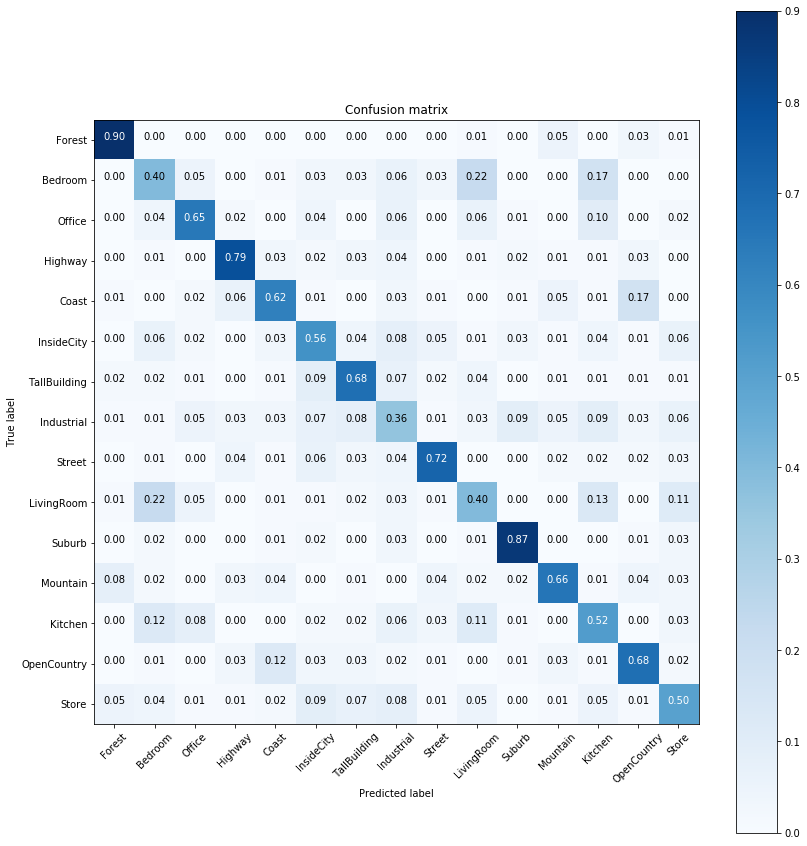

In [13]:
#Third combination:
# Confusion matrix
cm3 = confusion_matrix(test_label, pred3)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>